# Setup

In [1]:
import os
os.chdir('../..')

In [2]:
import torch

from tqdm import tqdm
from torch import Tensor as _T

from ddpm.model.main.multiepoch import MultiPreparatoryHVAEReverseProcess

from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch

from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles, polar2cart

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cmx
import matplotlib.colors as colors

import numpy as np
from scipy.spatial.distance import pdist

In [529]:

base_dir_name = 'hvae_with_dendritic_20250410'

device = 'cuda'


# analysis_args = ConfigNamepace.from_yaml_path(sys.argv[1], strict_access = True)
# yaml_name = sys.argv[1].split('/')[-1].split('.')[0]
# save_base = '/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/fixed_points'
# save_path = os.path.join(save_base, yaml_name)
# _, save_path, _ = configure_logging_paths(save_path, [])
# analysis_args.write_to_yaml(os.path.join(save_path, "args.yaml"))
# print(save_path)
# run_name = analysis_args.run_name


# run_name = 'run_a2_probe_cued_rnn_no_swap_1'
# run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
# run_name = 'run_a4_probe_cued_diffusion_flat_swap_1'
run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_0'
# run_name = 'run_a6_probe_cued_diffusion_sharp_swap_2'


_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess


for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False


# Stimulus design

In [530]:
grid_points = 24
minimum_margin = torch.pi / task.task_variable_gen.min_sep

# Create unique feature values evenly spaced around the circle
unique_feature_values = torch.linspace(0, 2 * torch.pi, grid_points+1)[:-1]
unique_feature_values = rectify_angles(unique_feature_values)

# Create all possible combinations
stim1_grid, stim2_grid = torch.meshgrid(unique_feature_values, unique_feature_values, indexing='ij')
stim1_probe_features = stim1_grid.reshape(-1, 1)
stim2_probe_features = stim2_grid.reshape(-1, 1)

# Stack them together
all_probe_features = torch.cat([stim1_probe_features, stim2_probe_features], dim=1)
all_report_features = all_probe_features.clone()

all_probe_features = all_probe_features.unsqueeze(1).repeat(1, grid_points * grid_points, 1).reshape(grid_points ** 4, 2)
all_report_features = all_report_features.unsqueeze(0).repeat(grid_points * grid_points, 1, 1).reshape(grid_points ** 4, 2)

all_probe_features = all_probe_features.repeat(2, 1)
all_report_features = all_report_features.repeat(2, 1)

# Create mask for valid combinations (respecting minimum margin)
probe_angle_diff = rectify_angles(all_probe_features[:,0] - all_probe_features[:,1])
report_angle_diff = rectify_angles(all_report_features[:,0] - all_report_features[:,1])
valid_trial_mask = (probe_angle_diff.abs() >= minimum_margin) & (report_angle_diff.abs() >= minimum_margin)

selected_feature_idx = torch.concat([torch.zeros(grid_points ** 4), torch.ones(grid_points ** 4)]).int()
selected_feature_idx_valid_trials = selected_feature_idx[valid_trial_mask]

batch_size = valid_trial_mask.sum()
num_samples = 1

# Run trial

In [531]:
override_stimulus_features = {
    'probe_features': all_probe_features[valid_trial_mask],
    'report_features': all_report_features[valid_trial_mask],
}
override_stimulus_cart_features = {}
for k in override_stimulus_features.keys():
    override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

override_stimulus_features_dict = dict(
    **override_stimulus_features,
    **override_stimulus_cart_features,
    cued_item_idx = selected_feature_idx_valid_trials
)

task_variable_dict = task.task_variable_gen.generate_variable_dict(
    batch_size = batch_size,
    override_stimulus_features_dict=override_stimulus_features_dict
)

trial_information = task.generate_trial_information(
    batch_size=batch_size, num_samples=num_samples, override_task_variable_information = task_variable_dict
)

all_feature_data = torch.concat([
    trial_information.task_variable_information['probe_features_cart'].reshape(batch_size, 4),
    trial_information.task_variable_information['report_features_cart'].reshape(batch_size, 4),
], dim = -1)


with torch.no_grad():
    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        # prep_network_inputs=[
        #     pni[[0]] for pni in trial_information.prep_network_inputs
        # ],
        # diffusion_network_inputs=[
        #     dni[[0]] for dni in trial_information.diffusion_network_inputs
        # ],
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[batch_size, num_samples],
        noise_scaler=1.0,
    )



actual_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'].squeeze(1)[:,[1,0]].T) - all_report_features[valid_trial_mask][range(valid_trial_mask.sum()), selected_feature_idx[valid_trial_mask]]).numpy()
swapped_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'].squeeze(1)[:,[1,0]].T) - all_report_features[valid_trial_mask][range(valid_trial_mask.sum()), 1 - selected_feature_idx[valid_trial_mask]]).numpy()

fig = plt.figure(figsize = (10, 5))
plt.hist(actual_errors, 50)
plt.hist(swapped_errors, 50)
plt.show()

swapped_trials = torch.tensor(np.abs(actual_errors) > np.abs(swapped_errors)).bool()
print(swapped_trials.float().mean())

tensor(0.2457)


# Report representation during delay

### Fix both probes and one report, then vary other report and seperate by probe

In [532]:
unique_probe_combinations = all_probe_features[::grid_points*grid_points]

# (novel_samples_dict['embedded_sample_trajectory'] @ ddpm_model.auxiliary_embedding_matrix.cpu().T) == novel_samples_dict['sample_trajectory']

pcaable_data = novel_samples_prep_dicts[3]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# pcaable_data = novel_samples_prep_dicts[1]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.sample_subspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-15,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()

num_probe_combs = 6

magma = plt.get_cmap("magma")
cNorm = colors.Normalize(vmin=0, vmax=19)
cmap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
cmap_colors = torch.tensor([cmap.to_rgba(_) for _ in range(19)])
cmap.set_array([])

pca_dims = 3

ax_rows = 2
num_ax_cols = num_probe_combs
fig = plt.figure(figsize=(4 * num_ax_cols + 8, 4 * ax_rows))
gs = gridspec.GridSpec(ax_rows, num_ax_cols + 2)

# Create regular subplots
axes = [[fig.add_subplot(gs[r, c], projection='3d' if pca_dims > 2 and r == 0 else None) for c in range(num_ax_cols)] for r in range(ax_rows)]
axes = np.array(axes)
big_ax = fig.add_subplot(gs[:, -2:]) 

ic = -1

fig.suptitle(f'{run_name}\n1 axes = 1 unique combination of probe feature values')
axes[0,0].set_ylabel('Fixing stimulus 1 report feature value')


def avg_pairwise_distance(points):
    if len(points) < 2:
        return 0
    # pdist computes pairwise distances in a condensed form
    distances = pdist(points)
    return np.mean(distances)


all_swap_probs = []
all_dispersion_ratios = []

all_stim1_vals = []


for _j in tqdm(range(grid_points ** 2)):

    probe_comb = unique_probe_combinations[[_j]]
    both_probe_fixed_mask = (all_probe_features == probe_comb).all(-1)[valid_trial_mask]
    if not both_probe_fixed_mask.any():
        continue
    else:
        ic += 1


    if ic < num_probe_combs:
        axes[1,ic].imshow(trial_information.prep_network_inputs[0][both_probe_fixed_mask][0,0])
        axes[1,ic].set_title(probe_comb.tolist())


    for _k, fval in enumerate(unique_feature_values[:,None,None]):

        stim1_fixed_mask = (all_report_features[:,[0]] == fval).squeeze(-1)                     # All possible combinations
        stim1_and_probe_fixed_mask = both_probe_fixed_mask & stim1_fixed_mask[valid_trial_mask] # All valid combinations
        relevant_stim1_cued_mask = (selected_feature_idx_valid_trials == 0)[stim1_and_probe_fixed_mask] # Relevant trials

        pcaable_data_fixed_report1 = pcaable_data[stim1_and_probe_fixed_mask]                   # Relevant trials
        pca_obj_fixed_report1 = PCA(n_components=pca_dims, whiten = True).fit(pcaable_data_fixed_report1)
        pcaed_data = pca_obj_fixed_report1.transform(pcaable_data_fixed_report1)

        dispersion_ratio = avg_pairwise_distance(pcaed_data[relevant_stim1_cued_mask]) / avg_pairwise_distance(pcaed_data[~relevant_stim1_cued_mask])
        relevant_swapped_trials = swapped_trials[stim1_and_probe_fixed_mask]
        swap_prob = relevant_swapped_trials[relevant_stim1_cued_mask].float().mean().item()
        var_expl = pca_obj_fixed_report1.explained_variance_ratio_.sum().item()

        all_dispersion_ratios.append(dispersion_ratio)
        all_swap_probs.append(swap_prob)
        all_stim1_vals.append(all_report_features[:,[1]][stim1_fixed_mask & valid_trial_mask])

        if ic < num_probe_combs and _k == 0:
            axes[0,ic].scatter(*pcaed_data[relevant_stim1_cued_mask].T, s = 30, color = cmap_colors.numpy(), marker = 'o', label = 'fixed item is cued')
            axes[0,ic].scatter(*pcaed_data[~relevant_stim1_cued_mask].T, s = 30, color = cmap_colors.numpy(), marker = 'x', label = 'fixed item is distractor')
            axes[0,ic].set_title(f"Var explained {round(var_expl, 4)}\nDispersion ratio {round(dispersion_ratio, 4)}\nSwap prop{round(swap_prob, 4)}")
    
axes[0,0].legend()

big_ax.scatter(all_dispersion_ratios, all_swap_probs)
big_ax.set_xlabel('Disperion ratios')
big_ax.set_ylabel('Swap probabilities')

  7%|▋         | 38/576 [00:02<00:33, 16.23it/s]


KeyboardInterrupt: 

### Fix one probe, one report, and cue the fixed item. Then vary other item probe and report, and seperate by swapped

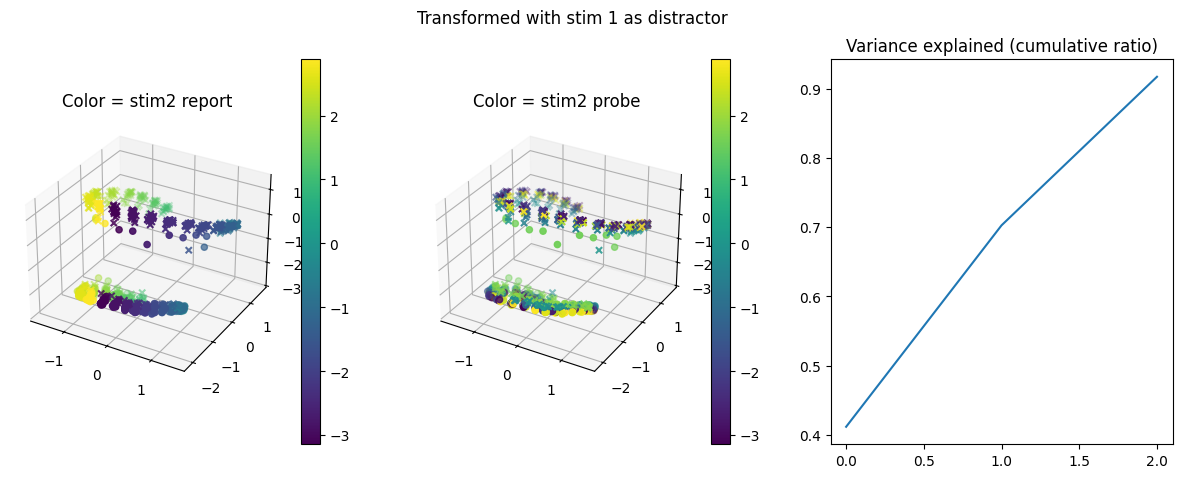

In [533]:
fixed_probe_val = unique_feature_values[3]
fixed_report_val = unique_feature_values[1]

fixed_stim1_trials_mask = ((all_report_features[:,0] == fixed_report_val) & (all_probe_features[:,0] == fixed_probe_val))

fixed_stim1_data = novel_samples_prep_dicts[3]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# fixed_stim1_data = novel_samples_prep_dicts[1]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# fixed_stim1_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.sample_subspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-15,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()


fixed_stim1_as_cued_data = fixed_stim1_data[((selected_feature_idx == 0) & fixed_stim1_trials_mask)[valid_trial_mask]]
fixed_stim1_as_distractor_data = fixed_stim1_data[((selected_feature_idx == 1) & fixed_stim1_trials_mask)[valid_trial_mask]]

stim2_report_when_stim1_cued = all_report_features[valid_trial_mask][((selected_feature_idx == 0) & fixed_stim1_trials_mask)[valid_trial_mask]][:,1]
stim2_probe_when_stim1_cued = all_probe_features[valid_trial_mask][((selected_feature_idx == 0) & fixed_stim1_trials_mask)[valid_trial_mask]][:,1]
stim2_report_when_stim1_distractor = all_report_features[valid_trial_mask][((selected_feature_idx == 1) & fixed_stim1_trials_mask)[valid_trial_mask]][:,1]
stim2_probe_when_stim1_distractor = all_probe_features[valid_trial_mask][((selected_feature_idx == 1) & fixed_stim1_trials_mask)[valid_trial_mask]][:,1]




pca_dim = 3
plot_cross_pcaed = True


pca_obj_fixed_stim1_as_cued_data = PCA(n_components=pca_dim, whiten = True).fit(fixed_stim1_as_cued_data)
pcaed_fixed_stim1_as_cued_data = pca_obj_fixed_stim1_as_cued_data.transform(fixed_stim1_as_cued_data)
cross_pcaed_fixed_stim1_as_distractor_data = pca_obj_fixed_stim1_as_cued_data.transform(fixed_stim1_as_distractor_data)

fig_stim1_as_cued = plt.figure(figsize = (15, 5))
fig_stim1_as_cued.suptitle('Transformed with stim 1 as cued data')
ax_color_by_report = fig_stim1_as_cued.add_subplot(1, 3, 1, projection = '3d' if pca_dim == 3 else None)
ax_color_by_probe = fig_stim1_as_cued.add_subplot(1, 3, 2, projection = '3d' if pca_dim == 3 else None)
ax_var_explained = fig_stim1_as_cued.add_subplot(1, 3, 3)

ax_color_by_report.set_title('Color = stim2 report')
ax_color_by_probe.set_title('Color = stim2 probe')
ax_var_explained.set_title('Variance explained (cumulative ratio)')

sc = ax_color_by_report.scatter(*pcaed_fixed_stim1_as_cued_data.T, c = stim2_report_when_stim1_cued)
if plot_cross_pcaed:
    sc = ax_color_by_report.scatter(*cross_pcaed_fixed_stim1_as_distractor_data.T, c = stim2_report_when_stim1_cued, marker = 'x')
plt.colorbar(sc)
sc = ax_color_by_probe.scatter(*pcaed_fixed_stim1_as_cued_data.T, c = stim2_probe_when_stim1_cued, label = 'Stim 1 is cued')
if plot_cross_pcaed:
    sc = ax_color_by_probe.scatter(*cross_pcaed_fixed_stim1_as_distractor_data.T, c = stim2_probe_when_stim1_cued, label = 'Stim 1 is distractor', marker = 'x')
plt.colorbar(sc)
ax_color_by_probe.legend()
ax_var_explained.plot(pca_obj_fixed_stim1_as_cued_data.explained_variance_ratio_.cumsum())





pca_obj_fixed_stim1_as_distractor_data = PCA(n_components=pca_dim, whiten = True).fit(fixed_stim1_as_distractor_data)
pcaed_fixed_stim1_as_distractor_data = pca_obj_fixed_stim1_as_distractor_data.transform(fixed_stim1_as_distractor_data)
cross_pcaed_fixed_stim1_as_cued_data = pca_obj_fixed_stim1_as_distractor_data.transform(fixed_stim1_as_cued_data)

fig_stim1_as_distractor = plt.figure(figsize = (15, 5))
fig_stim1_as_distractor.suptitle('Transformed with stim 1 as distractor')
ax_color_by_report = fig_stim1_as_distractor.add_subplot(1, 3, 1, projection = '3d' if pca_dim == 3 else None)
ax_color_by_probe = fig_stim1_as_distractor.add_subplot(1, 3, 2, projection = '3d' if pca_dim == 3 else None)
ax_var_explained = fig_stim1_as_distractor.add_subplot(1, 3, 3)

ax_color_by_report.set_title('Color = stim2 report')
ax_color_by_probe.set_title('Color = stim2 probe')
ax_var_explained.set_title('Variance explained (cumulative ratio)')

sc = ax_color_by_report.scatter(*pcaed_fixed_stim1_as_distractor_data.T, c = stim2_report_when_stim1_distractor, marker = 'x')
if plot_cross_pcaed:
    sc = ax_color_by_report.scatter(*cross_pcaed_fixed_stim1_as_cued_data.T, c = stim2_report_when_stim1_distractor)
plt.colorbar(sc)
sc = ax_color_by_probe.scatter(*pcaed_fixed_stim1_as_distractor_data.T, c = stim2_probe_when_stim1_distractor, marker = 'x', label = 'Stim 1 is distractor')
if plot_cross_pcaed:
    sc = ax_color_by_probe.scatter(*cross_pcaed_fixed_stim1_as_cued_data.T, c = stim2_probe_when_stim1_distractor, label = 'Stim 1 is cued')
plt.colorbar(sc)
ax_var_explained.plot(pca_obj_fixed_stim1_as_distractor_data.explained_variance_ratio_.cumsum())




pca_obj_fixed_stim1_data = PCA(n_components=pca_dim, whiten = True).fit(fixed_stim1_data)
pcaed_fixed_stim1_data = pca_obj_fixed_stim1_data.transform(fixed_stim1_data)

fig_stim1 = plt.figure(figsize = (15, 5))
fig_stim1.suptitle('Stim 1 both')
ax_color_by_report = fig_stim1.add_subplot(1, 3, 1, projection = '3d' if pca_dim == 3 else None)
ax_color_by_probe = fig_stim1.add_subplot(1, 3, 2, projection = '3d' if pca_dim == 3 else None)
ax_var_explained = fig_stim1.add_subplot(1, 3, 3)

ax_color_by_report.set_title('Color = stim2 report')
ax_color_by_probe.set_title('Color = stim2 probe')
ax_var_explained.set_title('Variance explained (cumulative ratio)')

ax_color_by_report.scatter(*pcaed_fixed_stim1_data[((selected_feature_idx == 0) & fixed_stim1_trials_mask)[valid_trial_mask]].T, c = stim2_report_when_stim1_cued)
ax_color_by_probe.scatter(*pcaed_fixed_stim1_data[((selected_feature_idx == 0) & fixed_stim1_trials_mask)[valid_trial_mask]].T, c = stim2_probe_when_stim1_cued)
ax_color_by_report.scatter(*pcaed_fixed_stim1_data[((selected_feature_idx == 1) & fixed_stim1_trials_mask)[valid_trial_mask]].T, c = stim2_report_when_stim1_distractor, marker = 'x')
ax_color_by_probe.scatter(*pcaed_fixed_stim1_data[((selected_feature_idx == 1) & fixed_stim1_trials_mask)[valid_trial_mask]].T, c = stim2_probe_when_stim1_distractor, marker = 'x')
ax_var_explained.plot(pca_obj_fixed_stim1_data.explained_variance_ratio_.cumsum())

# Fix one stimulus entirely (like above) -> trajectories of many trials

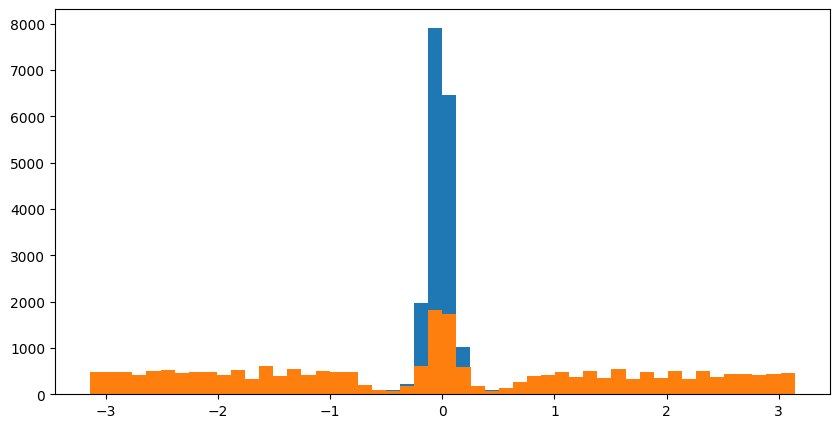

torch.Size([722, 32]) tensor(0.2260)


In [534]:
fixed_stim1_probe_val = unique_feature_values[6]
fixed_stim1_report_val = unique_feature_values[6]


fixed_stim1_trials_mask = ((all_report_features[:,0] == fixed_stim1_report_val) & (all_probe_features[:,0] == fixed_stim1_probe_val))[valid_trial_mask]

override_stimulus_features = {
    'probe_features': all_probe_features[valid_trial_mask][fixed_stim1_trials_mask],
    'report_features': all_report_features[valid_trial_mask][fixed_stim1_trials_mask],
}
override_stimulus_cart_features = {}
for k in override_stimulus_features.keys():
    override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

override_stimulus_features_dict = dict(
    **override_stimulus_features,
    **override_stimulus_cart_features,
    cued_item_idx = selected_feature_idx_valid_trials[fixed_stim1_trials_mask]
)

fixed_stim1_set_batch_size = fixed_stim1_trials_mask.sum()
num_samples_fixed_stim1 = 32

task_variable_dict = task.task_variable_gen.generate_variable_dict(
    batch_size = fixed_stim1_set_batch_size,
    override_stimulus_features_dict=override_stimulus_features_dict
)

trial_information = task.generate_trial_information(
    batch_size = fixed_stim1_set_batch_size, num_samples=num_samples_fixed_stim1, override_task_variable_information = task_variable_dict
)

all_feature_data = torch.concat([
    trial_information.task_variable_information['probe_features_cart'].reshape(fixed_stim1_set_batch_size, 4),
    trial_information.task_variable_information['report_features_cart'].reshape(fixed_stim1_set_batch_size, 4),
], dim = -1)


with torch.no_grad():
    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        # prep_network_inputs=[
        #     pni[[0]] for pni in trial_information.prep_network_inputs
        # ],
        # diffusion_network_inputs=[
        #     dni[[0]] for dni in trial_information.diffusion_network_inputs
        # ],
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[fixed_stim1_set_batch_size, num_samples_fixed_stim1],
        noise_scaler=1.0,
    )


actual_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'][:,:,[1,0]].T).T - all_report_features[valid_trial_mask][fixed_stim1_trials_mask][range(fixed_stim1_trials_mask.sum()), selected_feature_idx[valid_trial_mask][fixed_stim1_trials_mask]].unsqueeze(1)).numpy()
swapped_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'][:,:,[1,0]].T).T - all_report_features[valid_trial_mask][fixed_stim1_trials_mask][range(fixed_stim1_trials_mask.sum()), 1 - selected_feature_idx[valid_trial_mask][fixed_stim1_trials_mask]].unsqueeze(1)).numpy()

fig = plt.figure(figsize = (10, 5))
plt.hist(actual_errors.flatten(), 50)
plt.hist(swapped_errors.flatten(), 50)
plt.show()

swapped_trials = torch.tensor(np.abs(actual_errors) > np.abs(swapped_errors)).bool()
print(swapped_trials.shape, swapped_trials.float().mean())

### Visualise case where stim1 (fixed one) is cued

In [535]:
stim1_cued_mask = selected_feature_idx_valid_trials[fixed_stim1_trials_mask] == 0

stim2_report_when_stim1_cued = all_report_features[valid_trial_mask][fixed_stim1_trials_mask][stim1_cued_mask][:,1]
stim2_probe_when_stim1_cued = all_probe_features[valid_trial_mask][fixed_stim1_trials_mask][stim1_cued_mask][:,1]


fixed_stim1_many_trials_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:num_samples_fixed_stim1,-1,:].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu()
fixed_stim1_many_trials_data_traj = [novel_samples_dict['embedded_sample_trajectory'].data[:,:num_samples_fixed_stim1,10 * i - 1,:].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu() for i in range(1, 5)]

fixed_stim1_as_cued_many_trials_data = fixed_stim1_many_trials_data[stim1_cued_mask]
fixed_stim1_as_cued_many_trials_data_reshaped = fixed_stim1_as_cued_many_trials_data.reshape(int(fixed_stim1_set_batch_size * num_samples_fixed_stim1 / 2), -1)

fixed_stim1_as_cued_many_trials_data_traj = [traj[stim1_cued_mask] for traj in fixed_stim1_many_trials_data_traj]
fixed_stim1_as_cued_many_trials_data_traj_reshaped = [traj.reshape(int(fixed_stim1_set_batch_size * num_samples_fixed_stim1 / 2), -1) for traj in fixed_stim1_as_cued_many_trials_data_traj]

stim2_probe_when_stim1_cued_many_trials = stim2_probe_when_stim1_cued.unsqueeze(1).repeat(1, num_samples_fixed_stim1).reshape(-1)
stim2_report_when_stim1_cued_many_trials = stim2_report_when_stim1_cued.unsqueeze(1).repeat(1, num_samples_fixed_stim1).reshape(-1)

relevant_swapped_trials = swapped_trials[stim1_cued_mask]
relevant_swapped_trials_reshaped = relevant_swapped_trials.reshape(-1)


pca_dim = 3

pca_obj_fixed_stim1_as_cued_many_trials = PCA(n_components=pca_dim, whiten = False).fit(fixed_stim1_as_cued_many_trials_data_reshaped)
pcaed_fixed_stim1_as_cued_many_trials_reshaped = pca_obj_fixed_stim1_as_cued_many_trials.transform(fixed_stim1_as_cued_many_trials_data_reshaped)
pcaed_fixed_stim1_as_cued_many_trials_traj_reshaped = [pca_obj_fixed_stim1_as_cued_many_trials.transform(traj) for traj in fixed_stim1_as_cued_many_trials_data_traj_reshaped]

fig_stim1 = plt.figure(figsize = (15, 5))
fig_stim1.suptitle('Stim 1 both')
ax_color_by_report = fig_stim1.add_subplot(1, 3, 1, projection = '3d' if pca_dim == 3 else None)
ax_color_by_probe = fig_stim1.add_subplot(1, 3, 2, projection = '3d' if pca_dim == 3 else None)
ax_var_explained = fig_stim1.add_subplot(1, 3, 3)

ax_color_by_report.set_title('Color = stim2 report')
ax_color_by_probe.set_title('Color = stim2 probe')
ax_var_explained.set_title('Variance explained (cumulative ratio)')

ax_color_by_report.scatter(*pcaed_fixed_stim1_as_cued_many_trials_reshaped[~relevant_swapped_trials_reshaped].T, c = stim2_report_when_stim1_cued_many_trials[~relevant_swapped_trials_reshaped], label = 'correct trials')
ax_color_by_probe.scatter(*pcaed_fixed_stim1_as_cued_many_trials_reshaped[~relevant_swapped_trials_reshaped].T, c = stim2_probe_when_stim1_cued_many_trials[~relevant_swapped_trials_reshaped])

ax_color_by_report.scatter(*pcaed_fixed_stim1_as_cued_many_trials_reshaped[relevant_swapped_trials_reshaped].T, c = stim2_report_when_stim1_cued_many_trials[relevant_swapped_trials_reshaped], marker = 'x', label = 'swapped trials')
ax_color_by_probe.scatter(*pcaed_fixed_stim1_as_cued_many_trials_reshaped[relevant_swapped_trials_reshaped].T, c = stim2_probe_when_stim1_cued_many_trials[relevant_swapped_trials_reshaped], marker = 'x')

ax_color_by_report.legend()

ax_var_explained.plot(pca_obj_fixed_stim1_as_cued_many_trials.explained_variance_ratio_.cumsum())

# for idx_traj, _traj in enumerate(pcaed_fixed_stim1_as_cued_many_trials_traj_reshaped):
#     alpha = (len(pcaed_fixed_stim1_as_cued_many_trials_traj_reshaped) - idx_traj) / len(pcaed_fixed_stim1_as_cued_many_trials_traj_reshaped) * 10
#     ax_color_by_probe.scatter(*_traj.T, c = stim2_probe_when_stim1_cued_many_trials, s = alpha)
#     ax_color_by_report.scatter(*_traj.T, c = stim2_report_when_stim1_cued_many_trials, s = alpha)

#### First 2 PCs = distractor report. PC3 = swapped?
#### This third PC would therefore be a target-distractor dividing subspace

In [537]:
seperating_array = stim2_report_when_stim1_cued_many_trials

unique_seperating_values = seperating_array.unique()

fig, axes = plt.subplots(1, len(unique_seperating_values), figsize = (5 * len(unique_seperating_values), 5))

data_to_seperate = pcaed_fixed_stim1_as_cued_many_trials_reshaped

for idrv, distractor_report_val in enumerate(unique_seperating_values):
    relevant_mean = data_to_seperate[seperating_array == distractor_report_val][:,2].mean()
    axes[idrv].hist(data_to_seperate[(~relevant_swapped_trials_reshaped) & (seperating_array == distractor_report_val)][:,2] - relevant_mean, color = 'blue')
    axes[idrv].hist(data_to_seperate[(relevant_swapped_trials_reshaped) & (seperating_array == distractor_report_val)][:,2] - relevant_mean, color = 'red')
    axes[idrv].set_title((distractor_report_val - fixed_stim1_report_val).abs().item())

post_cue_swap_vs_correct_direction = pca_obj_fixed_stim1_as_cued_many_trials.components_[2]

#### This target-distractor dividing subspace is supposed to be orthogonal to the 'probe feature' subspace before the cue (during the delay)

- For us, the probe space is not an easy 1D seperation, like in the Alleman paper (up vs down)
- Instead it is part of an 8D complex, storing 2 times * 2 feature dimensions
- Therefore, we should just extract the dimensions from which the probe is decodable during the delay, then checking if this 

In [509]:
fixed_stim1_delay_time_repr_data = novel_samples_prep_dicts[1]['preparatory_trajectory'].data[:,:,-5,:].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu()

fixed_stim1_as_cued_delay_time_repr_data = fixed_stim1_delay_time_repr_data[stim1_cued_mask]
fixed_stim1_as_cued_delay_time_repr_data_reshaped = fixed_stim1_as_cued_delay_time_repr_data.reshape(int(fixed_stim1_set_batch_size * num_samples_fixed_stim1 / 2), -1)

pca_dim = 3
pca_obj_fixed_stim1_as_cued_delay_time_repr_data_reshaped = PCA(n_components=pca_dim, whiten = False).fit(fixed_stim1_as_cued_delay_time_repr_data_reshaped)
pcaed_fixed_stim1_as_cued_delay_time_repr_data_reshaped = pca_obj_fixed_stim1_as_cued_delay_time_repr_data_reshaped.transform(fixed_stim1_as_cued_delay_time_repr_data_reshaped)


fig_stim1 = plt.figure(figsize = (15, 5))
fig_stim1.suptitle('Stim 1 both')
ax_color_by_report = fig_stim1.add_subplot(1, 3, 1, projection = '3d' if pca_dim == 3 else None)
ax_color_by_probe = fig_stim1.add_subplot(1, 3, 2, projection = '3d' if pca_dim == 3 else None)
ax_var_explained = fig_stim1.add_subplot(1, 3, 3)

ax_color_by_report.set_title('Color = stim2 report')
ax_color_by_probe.set_title('Color = stim2 probe')
ax_var_explained.set_title('Variance explained (cumulative ratio)')

ax_color_by_report.scatter(*pcaed_fixed_stim1_as_cued_delay_time_repr_data_reshaped[~relevant_swapped_trials_reshaped].T, c = stim2_report_when_stim1_cued_many_trials[~relevant_swapped_trials_reshaped], label = 'correct trials')
ax_color_by_probe.scatter(*pcaed_fixed_stim1_as_cued_delay_time_repr_data_reshaped[~relevant_swapped_trials_reshaped].T, c = stim2_probe_when_stim1_cued_many_trials[~relevant_swapped_trials_reshaped])

ax_color_by_report.scatter(*pcaed_fixed_stim1_as_cued_delay_time_repr_data_reshaped[relevant_swapped_trials_reshaped].T, c = stim2_report_when_stim1_cued_many_trials[relevant_swapped_trials_reshaped], marker = 'x', label = 'swapped trials')
ax_color_by_probe.scatter(*pcaed_fixed_stim1_as_cued_delay_time_repr_data_reshaped[relevant_swapped_trials_reshaped].T, c = stim2_probe_when_stim1_cued_many_trials[relevant_swapped_trials_reshaped], marker = 'x')

ax_color_by_report.legend()

ax_var_explained.plot(pca_obj_fixed_stim1_as_cued_delay_time_repr_data_reshaped.explained_variance_ratio_.cumsum())

Sanity check just to be sure that the same seperability is not possible here...

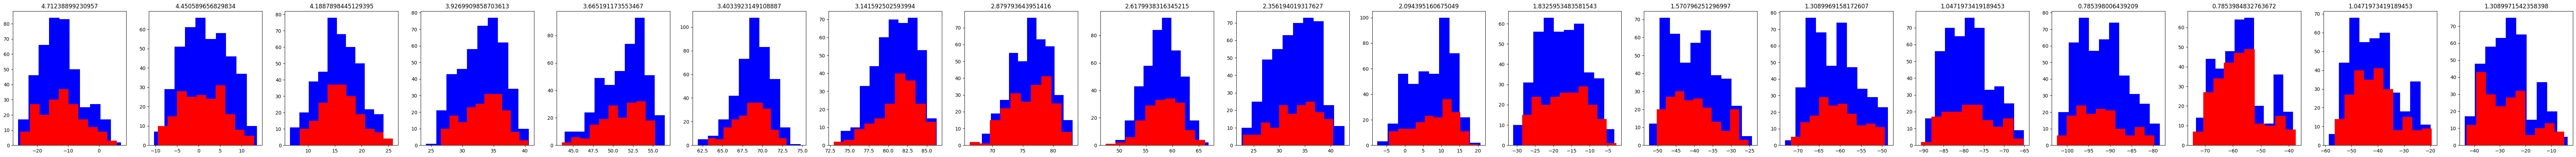

In [510]:
seperating_array = stim2_report_when_stim1_cued_many_trials

unique_seperating_values = seperating_array.unique()

fig, axes = plt.subplots(1, len(unique_seperating_values), figsize = (5 * len(unique_seperating_values), 5))

data_to_seperate = pcaed_fixed_stim1_as_cued_delay_time_repr_data_reshaped

for idrv, distractor_report_val in enumerate(unique_seperating_values):
    relevant_mean = data_to_seperate[seperating_array == distractor_report_val].mean()
    axes[idrv].hist(data_to_seperate[(~relevant_swapped_trials_reshaped) & (seperating_array == distractor_report_val)][:,2] - relevant_mean, color = 'blue')
    axes[idrv].hist(data_to_seperate[(relevant_swapped_trials_reshaped) & (seperating_array == distractor_report_val)][:,2] - relevant_mean, color = 'red')
    axes[idrv].set_title((distractor_report_val - fixed_stim1_report_val).abs().item())

However - it does look like the probe value is seperable along this dimension, for each report value cluster

While we're at it - we can do PCA on the original clusters, and see how aligned they are...

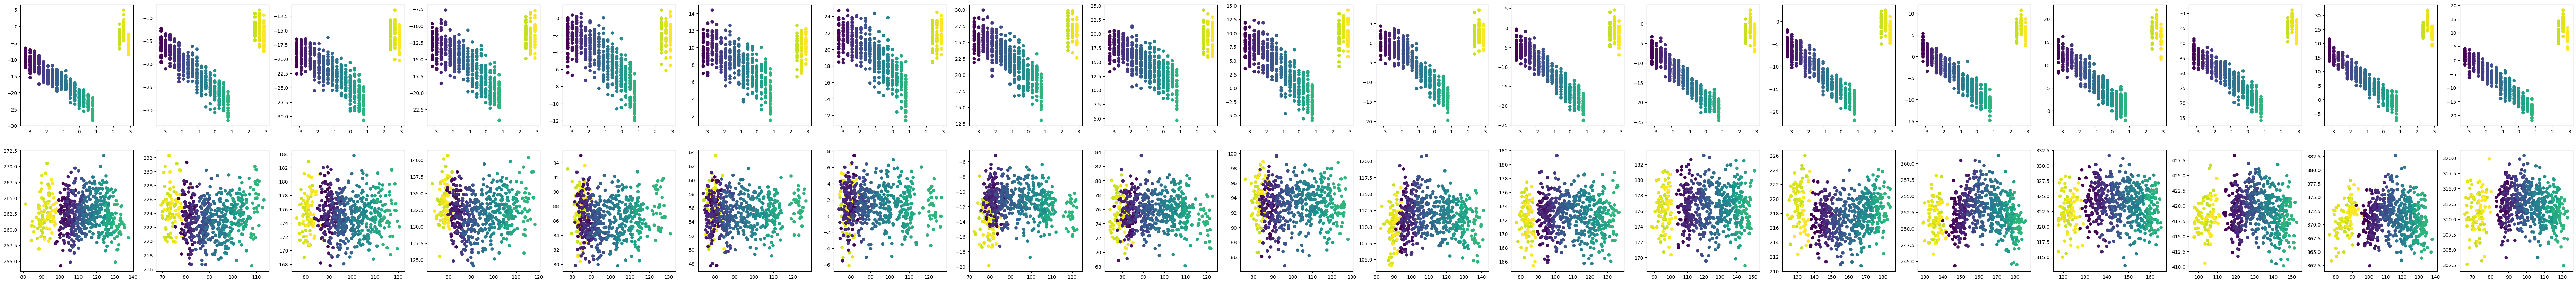

In [520]:
seperating_array = stim2_report_when_stim1_cued_many_trials

unique_seperating_values = seperating_array.unique()

pca_dim = 2

fig = plt.figure(figsize = (5 * len(unique_seperating_values), 10))
top_row_axes = [fig.add_subplot(2, len(unique_seperating_values), i+1) for i in range(len(unique_seperating_values))]
bot_row_axes = [fig.add_subplot(2, len(unique_seperating_values), len(unique_seperating_values)+i+1, projection = '3d' if pca_dim == 3 else None) for i in range(len(unique_seperating_values))]
axes = np.array([top_row_axes, bot_row_axes])


data_to_seperate = pcaed_fixed_stim1_as_cued_delay_time_repr_data_reshaped

all_report_seperated_components = []

for idrv, distractor_report_val in enumerate(unique_seperating_values):

    pcaed_data_cluster = data_to_seperate[seperating_array == distractor_report_val][...,2]
    original_data_cluster = fixed_stim1_as_cued_delay_time_repr_data_reshaped[seperating_array == distractor_report_val]
    data_cluster_probes = stim2_probe_when_stim1_cued_many_trials[seperating_array == distractor_report_val]

    axes[0,idrv].scatter(data_cluster_probes, pcaed_data_cluster, c = data_cluster_probes)

    report_seperated_pca_obj = PCA(n_components=pca_dim, whiten = True).fit(original_data_cluster)
    
    whitened_components = report_seperated_pca_obj.components_
    mean_vec = report_seperated_pca_obj.mean_
    components_global = whitened_components.copy()
    for i in range(len(report_seperated_pca_obj.explained_variance_)):
        components_global[i, :] *= np.sqrt(report_seperated_pca_obj.explained_variance_[i])
    
    components_global = components_global / np.linalg.norm(components_global, axis=1, keepdims=True)
    all_report_seperated_components.append(components_global)
    
    axes[1,idrv].scatter(*(components_global @ original_data_cluster.numpy().T), c = data_cluster_probes)

pre_cue_distractor_probe_direction = pca_obj_fixed_stim1_as_cued_delay_time_repr_data_reshaped.components_[2]

In [527]:
pre_cue_distractor_probe_direction @ post_cue_swap_vs_correct_direction

0.39977643135977203

In [528]:
all_distractor_probe_comp_angle_diffs = np.zeros([19, 19])
        
for icomp1, comp1 in enumerate(all_report_seperated_components):
    print(
        np.max(np.arccos(np.clip(np.linalg.svd(comp1 @ swap_vs_correct_direction[:,None], compute_uv=True).S, -1.0, 1.0))) / np.pi * 180
    )

    for icomp2, comp2 in enumerate(all_report_seperated_components):
        
        all_distractor_probe_comp_angle_diffs[icomp1, icomp2] = np.max(np.arccos(np.clip(np.linalg.svd(comp1 @ comp2.T, compute_uv=True).S, -1.0, 1.0))) / np.pi * 180

ims = plt.imshow(all_distractor_probe_comp_angle_diffs)
plt.colorbar(ims)

59.363410324701384
59.83241196794042
67.57843365794362
69.91330606248685
74.45194013327506
78.37857551127658
80.35920604841729
72.74573389880659
73.49566100459364
77.74243507315043
67.97450184863858
59.56323262960858
67.53211506640909
66.0826888991771
72.77414659099345
73.15000769009602
56.88518073052203
56.09843082329735
57.11484579624004


(955, 2)

### Rotation happening in the nullspace over the course of diffusion?

In [337]:
pca_dim = 3

all_ve2d, all_ve3d, all_components = [], [], []

for t_idx in range(ddpm_model.T):
    
    # Extract data for this timesteps
    fixed_stim1_many_trials_ts_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,t_idx,:].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu()
    fixed_stim1_as_cued_many_trials_ts_data = fixed_stim1_many_trials_ts_data[selected_feature_idx_valid_trials[fixed_stim1_trials_mask] == 0]
    fixed_stim1_as_cued_many_trials_ts_data_reshaped = fixed_stim1_as_cued_many_trials_ts_data.reshape(int(fixed_stim1_set_batch_size * num_samples_fixed_stim1 / 2), ddpm_model.sample_ambient_dims[0])
    pca_obj_fixed_stim1_as_cued_many_trials = PCA(n_components=pca_dim, whiten = True).fit(fixed_stim1_as_cued_many_trials_ts_data_reshaped)
    
    ve2d, ve3d = pca_obj_fixed_stim1_as_cued_many_trials.explained_variance_ratio_.cumsum()[[1, 2]]
    components = pca_obj_fixed_stim1_as_cued_many_trials.components_[:2]    # [2, 16]

    all_ve2d.append(ve2d)
    all_ve3d.append(ve3d)
    all_components.append(components)


all_comp_angle_diffs = np.zeros([ddpm_model.T, ddpm_model.T])

for icomp1, comp1 in enumerate(all_components):
    for icomp2, comp2 in enumerate(all_components):
        all_comp_angle_diffs[icomp1, icomp2] = np.max(np.arccos(np.clip(np.linalg.svd(comp1 @ comp2.T, compute_uv=True).S, -1.0, 1.0))) / np.pi * 180


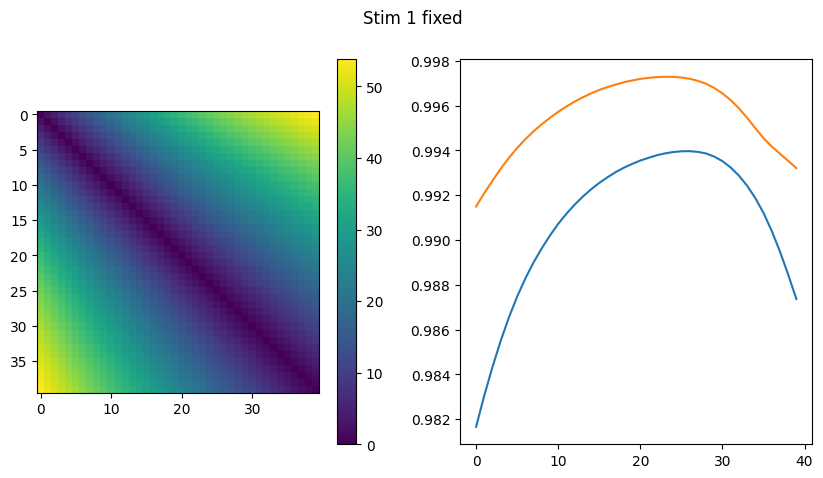

In [338]:
fig_angle_over_time = plt.figure(figsize = (10, 5))
fig_angle_over_time.suptitle('Stim 1 fixed')
ax_angle_imshow = fig_angle_over_time.add_subplot(1, 2, 1)
ax_vds = fig_angle_over_time.add_subplot(1, 2, 2)

ims = ax_angle_imshow.imshow(all_comp_angle_diffs)
plt.colorbar(ims)
ax_vds.plot(all_ve2d)
ax_vds.plot(all_ve3d)

# Fix both probes and run many trials -> swapping classifier analysis on diffusion period

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


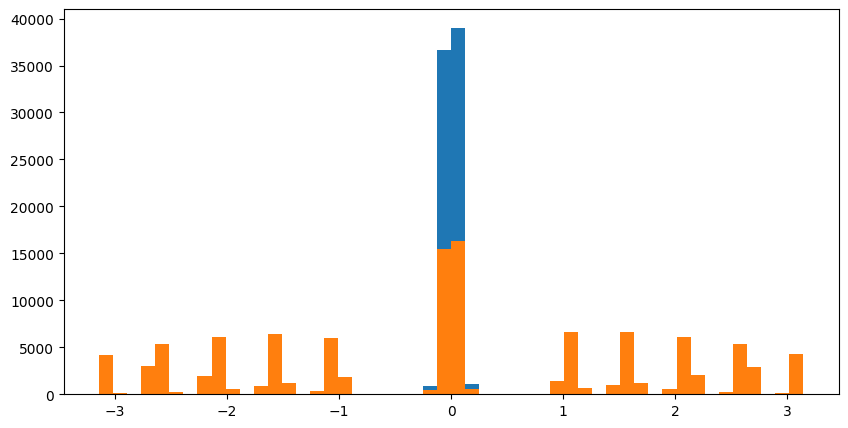

torch.Size([216, 512]) tensor(0.2970)


In [33]:
probe_comb = unique_probe_combinations[[6]]
both_probe_fixed_mask = (all_probe_features == probe_comb).all(-1)[valid_trial_mask]

override_stimulus_features = {
    'probe_features': all_probe_features[valid_trial_mask][both_probe_fixed_mask],
    'report_features': all_report_features[valid_trial_mask][both_probe_fixed_mask],
}
override_stimulus_cart_features = {}
for k in override_stimulus_features.keys():
    override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

override_stimulus_features_dict = dict(
    **override_stimulus_features,
    **override_stimulus_cart_features,
    cued_item_idx = selected_feature_idx_valid_trials[both_probe_fixed_mask]
)

fixed_probe_set_batch_size = both_probe_fixed_mask.sum()
num_samples_fixed_probes = 512

task_variable_dict = task.task_variable_gen.generate_variable_dict(
    batch_size = fixed_probe_set_batch_size,
    override_stimulus_features_dict=override_stimulus_features_dict
)

trial_information = task.generate_trial_information(
    batch_size = fixed_probe_set_batch_size, num_samples=num_samples_fixed_probes, override_task_variable_information = task_variable_dict
)

all_feature_data = torch.concat([
    trial_information.task_variable_information['probe_features_cart'].reshape(fixed_probe_set_batch_size, 4),
    trial_information.task_variable_information['report_features_cart'].reshape(fixed_probe_set_batch_size, 4),
], dim = -1)


with torch.no_grad():
    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        # prep_network_inputs=[
        #     pni[[0]] for pni in trial_information.prep_network_inputs
        # ],
        # diffusion_network_inputs=[
        #     dni[[0]] for dni in trial_information.diffusion_network_inputs
        # ],
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[fixed_probe_set_batch_size, num_samples_fixed_probes],
        noise_scaler=1.0,
    )



actual_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'][:,:,[1,0]].T).T - all_report_features[valid_trial_mask][both_probe_fixed_mask][range(both_probe_fixed_mask.sum()), selected_feature_idx[valid_trial_mask][both_probe_fixed_mask]].unsqueeze(1)).numpy()
swapped_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'][:,:,[1,0]].T).T - all_report_features[valid_trial_mask][both_probe_fixed_mask][range(both_probe_fixed_mask.sum()), 1 - selected_feature_idx[valid_trial_mask][both_probe_fixed_mask]].unsqueeze(1)).numpy()

fig = plt.figure(figsize = (10, 5))
plt.hist(actual_errors.flatten(), 50)
plt.hist(swapped_errors.flatten(), 50)
plt.show()

swapped_trials = torch.tensor(np.abs(actual_errors) > np.abs(swapped_errors)).bool()
print(swapped_trials.shape, swapped_trials.float().mean())

In [34]:
many_trials_data = novel_samples_dict['embedded_sample_trajectory'].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu()

# many_trials_data_flattend = many_trials_data.reshape(fixed_probe_set_batch_size * num_samples_fixed_probes, ddpm_model.sample_ambient_dims[0])
# many_trials_data_flattend.shape
many_trials_num_report_combinations, _, num_ts, num_neurons = many_trials_data.shape

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

swapped_data = swapped_trials.int().cpu().numpy()


all_mcc = np.zeros((many_trials_num_report_combinations, num_ts))



for stim_idx in tqdm(range(many_trials_num_report_combinations)):

    train_idx, test_idx = train_test_split(
        np.arange(num_samples_fixed_probes),
        test_size=0.3, random_state=42, stratify=swapped_data[stim_idx]
    )
    swapped_train_data = swapped_data[stim_idx, train_idx]
    swapped_test_data = swapped_data[stim_idx, test_idx]

    for ts_idx in range(num_ts):

        trials_train_data = many_trials_data[stim_idx, train_idx, ts_idx, :].cpu().numpy()
        trials_test_data = many_trials_data[stim_idx, test_idx, ts_idx, :].cpu().numpy()
        
        clf = GaussianNB()
        clf.fit(trials_train_data, swapped_train_data)
        y_pred = clf.predict(trials_test_data)

        all_mcc[stim_idx, ts_idx] = matthews_corrcoef(swapped_test_data, y_pred)

 20%|█▉        | 43/216 [00:04<00:19,  8.85it/s]


KeyboardInterrupt: 

(216, 40)


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   1.,   5.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 206.]),
 array([0.9697327 , 0.97033805, 0.9709434 , 0.97154874, 0.97215409,
        0.97275943, 0.97336478, 0.97397013, 0.97457547, 0.97518082,
        0.97578616, 0.97639151, 0.97699686, 0.9776022 , 0.97820755,
        0.97881289, 0.97941824, 0.98002358, 0.98062893, 0.98123428,
        0.98183962, 0.98244497, 0.98305031, 0.98365566, 0.98426101,
        0.98486635, 0.9854717 , 0.98607704, 0.98668239, 0.98728774,
        0.98789308, 0.98849843, 0.98910377, 0.98970912, 0.99031447,
        0.99091981, 0.99152516, 0.9921305 , 0.99273585, 0.99334119,
        0.99394654, 0.99455189, 0.99515723, 0.99576258, 0.99636792,
        0.99697327, 0.99757862, 0.99818396, 0.

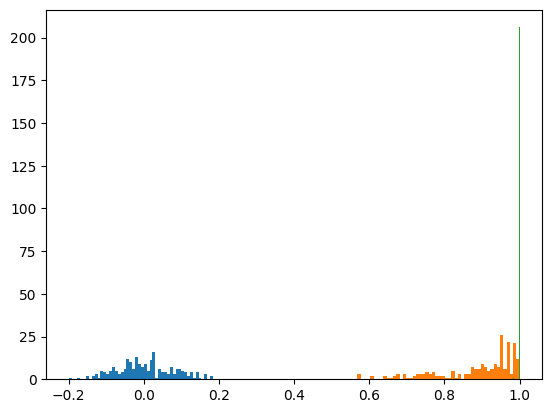

In [22]:
print(all_mcc.shape)
plt.hist(all_mcc[:,0], 50)
plt.hist(all_mcc[:,29], 50)
plt.hist(all_mcc[:,39], 50)

In [23]:
many_trials_data.shape

torch.Size([216, 512, 40, 16])

# Fixed point analysis

In [ ]:






def energy_function(neural_response: _T):
    delay_input = trial_information.prep_network_inputs[prep_epoch_idx]
    assert (delay_input == 0.0).all()
    time_embedding = ddpm_model.prep_time_embedding.expand(delay_duration, ddpm_model.prep_time_embedding.shape[1])
    network_input = ddpm_model.input_model(delay_input, delay_duration)
    xdot: _T = - neural_response + ddpm_model.residual_model(neural_response, time_embedding, network_input)
    return 0.5 * xdot.square().sum()


num_fp_opt_steps = 100000
activity_patterns = torch.nn.Parameter(delay_activity, requires_grad = True)
optim = torch.optim.Adam([activity_patterns], lr = 1e-2)

all_energies = []

for ots in tqdm(range(num_fp_opt_steps)):

    energy = energy_function(activity_patterns)
    total_energy = energy.mean()

    optim.zero_grad()
    total_energy.backward()
    optim.step()

    all_energies.append(total_energy.item())

    if ots % 100 == 0:

        plt.close('all')
        fig, axes = plt.subplots(2, 2, figsize = (20, 20))

        # Visualise PCA
        pcaable_data = activity_patterns.data[:,:,0,:].cpu().reshape(batch_size * num_samples, -1) # only one timestep rn
        pca = PCA(n_components=2, whiten = True).fit(pcaable_data)
        axes[0,1].scatter(*pca.transform(pcaable_data).T, c = color_array_flattened)

        # Visualise selected examples
        selected_pcaable_data = pcaable_data[only_stim2_changes_mask]
        pca_masked = PCA(n_components=2, whiten = True).fit(selected_pcaable_data)
        axes[1,0].scatter(*pca_masked.transform(selected_pcaable_data).T)

        # # Visualise CCA
        # item1_features = all_feature_data[:,[0,1,4,5]]
        # cca = CCA(n_components=2).fit(pcaable_data, item1_features)
        # activity_cross, stim_cross = cca.transform(pcaable_data, item1_features)
        # axes[1,0].scatter(*activity_cross.T, c = color_array_flattened)
        
        # Loss
        axes[0,0].plot(all_energies)
        
        fig.savefig('analysis/new_analysis/fixed_points_test.png')
